<img src="kit_logo.jpg" width="200" height="200" align="right"/>

##### Lehrstuhl für Analytics and Statistics (IOR)
##### Prof. Dr. Oliver Grothe
##### SS 2020

# Multivariate Verfahren
## Übung 10

### Aufgabe 5

Laden Sie den Datensatz *`imports`* aus Ilias herunter. Dieser enthält Daten
zu importierten Autos. 

Führen Sie eine LASSO Regression für den logarithmierten Preis
(1. Spalte im Datensatz) auf die restlichen Variablen des Datensatzes durch. Welche Regressoren würden Sie
verwenden?


#### Datenvorbereitung

- Daten einlesen:

In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import statsmodels.api as sm
import time
import matplotlib.pyplot as plt
df = pd.read_csv("./imports.csv",sep=',',header=None)
df = pd.DataFrame.to_numpy(df)

- Regressoren x:

In [2]:
x=df[:,1:14]
x[:3]

array([[9.980e+01, 1.766e+02, 6.620e+01, 5.430e+01, 2.337e+03, 1.090e+02,
        3.190e+00, 3.400e+00, 1.000e+01, 1.020e+02, 5.500e+03, 2.400e+01,
        3.000e+01],
       [9.940e+01, 1.766e+02, 6.640e+01, 5.430e+01, 2.824e+03, 1.360e+02,
        3.190e+00, 3.400e+00, 8.000e+00, 1.150e+02, 5.500e+03, 1.800e+01,
        2.200e+01],
       [1.058e+02, 1.927e+02, 7.140e+01, 5.570e+01, 2.844e+03, 1.360e+02,
        3.190e+00, 3.400e+00, 8.500e+00, 1.100e+02, 5.500e+03, 1.900e+01,
        2.500e+01]])

- Regressand y:

In [3]:
y=df[:,0]
y[:3]

array([9.5432, 9.7671, 9.7819])

- Standardisierung der Regressoren

In [4]:
# Standardization
from sklearn.preprocessing import StandardScaler
std_x = StandardScaler().fit_transform(x)

#### LASSO Regression

$\underset{\beta_0,\beta}{\min}  \frac{1}{2}\sum_{i=1}^{N}\left(y_i-\beta_0-x_i^T \beta\right)^2 + \alpha \sum_{j=1}^{p}\,\lVert \beta_j\rVert_1$

- $\alpha$: Regularization parameter
- $\beta_0$: Intercept term 
- $\lVert \beta \rVert_1$: L1-Norm of $\beta$


- Modell festlegen und anpassen

In [5]:
# lasso with cross validation
from sklearn import linear_model as lm
clf=lm.LassoCV(alphas=np.logspace(-4, 0, 100),cv=10)
t1 = time.time()
clf.fit(std_x,y)
t_lasso_cv = time.time() - t1

In [6]:
clf.intercept_

9.2383825

In [7]:
clf.alpha_

0.022051307399030457

In [8]:
clf.coef_

array([ 0.0179976 ,  0.01506694,  0.0747055 ,  0.        ,  0.21051377,
        0.        ,  0.        , -0.        ,  0.        ,  0.09065617,
        0.        , -0.00892686, -0.        ])

- Mean Squared Error (MSE)  
  * minIx: Index von $\alpha$ mit minimalem MSE 
  * alphaMin, bzw clf.alpha_:  $\alpha$ mit minimalem MSE 

In [9]:
mse=clf.mse_path_.mean(axis=-1)
minMSE = min(mse)

In [10]:
minIx = np.argmin(mse)
minIx

41

In [11]:
alphaMin=clf.alphas_[minIx]
alphaMin #same as the opt. alpha by minimaize mse: clf.alpha_

0.022051307399030457

- Standard error of MSE (SE)
  * seIx: Index von sparsamsten Model, d.h. Model innerhalb einer SE von bestem Model mit minimaler Anzahl Regressoren 
  * alphaSE:  $\alpha$ von sparsamsten Model 

In [28]:
se = clf.mse_path_.std(axis=-1)/ np.sqrt(clf.mse_path_.shape[0]) #Standard error of MSE for each alpha during cv
minplus1 = mse[minIx] + se[minIx];
seIx = np.argmax(mse[:minIx] <= minplus1)

seIx

32

In [27]:
alphaSE=clf.alphas_[seIx]
alphaSE

0.0509413801481638

#### Plot der LASSO-Pfad

- Plot der cross-validated-MSE von LASSO Anpassung

<ipython-input-30-9a79c8332fd1>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


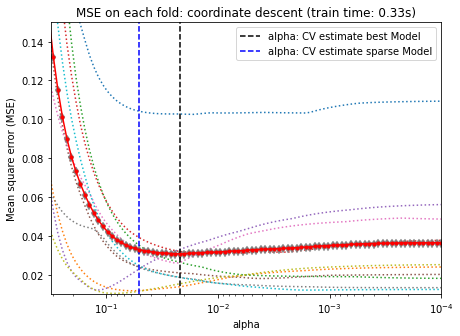

In [30]:
# a plot of mean value of MSE with error bars (SE) for the model fitted by lasso with that value of alpha
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ymin, ymax= 0.01, 0.15
xmin, xmax=10**(-4), 10**(-0.5)
ax = plt.axes()
ax.set_xscale("log")
ax.plot(clf.alphas_, clf.mse_path_, ':')
ax.errorbar(clf.alphas_, clf.mse_path_.mean(axis=-1),yerr=se, marker='.',color='red', ecolor='gray',
            elinewidth=0.5, lolims=True, uplims=True,capthick=0.3)
ax.axvline(clf.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate best Model')
ax.axvline(alphaSE, linestyle='--', color='b',
            label='alpha: CV estimate sparse Model')
ax.legend()
plt.xlabel('alpha')

plt.ylabel('Mean square error (MSE)')
plt.title('MSE on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.xlim(xmax, xmin)
plt.ylim(ymin, ymax)
plt.show()

- Berechnenung des Lasso-Pfads mit dem Koordinatenabstieg
  * coefs_lasso: fitted least-squares regression coefficients along the path.
  * alphas_lasso: Regularization coefficients along the path.
  * DF: Freiheitsgrad, Anzahl der Nicht-Null-Koeffizienten in coefs_lasso für jeden Wert von alphas_lasso, 

*Each column of coefs_lasso corresponds to a particular regularization coefficient in coefs_alphas (Regularization coefficients).*

In [15]:
alphas_lasso, coefs_lasso, _=lm.lasso_path(std_x,y,alphas=np.logspace(-4, 0, 100))

In [16]:
coefs_lasso.shape

(13, 100)

In [17]:
DF = sum(coefs_lasso!=0,1) # Number of nonzero coefficients in coefs_lasso for each value of alpha, a 1-by-L vector

In [18]:
xx = np.sum(np.abs(coefs_lasso), axis=0) # L1 Norm of coefficients along the path

- Trace Plot der Koeffizienten von LASSO Anpassung

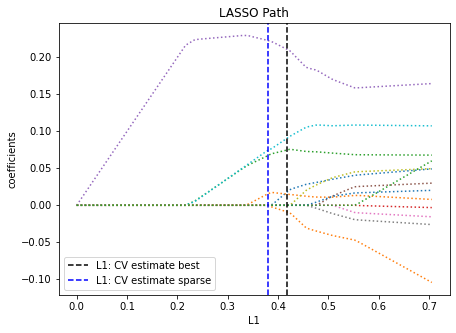

In [31]:
# a trace plot of the coefficients values against the L1 norm of coefficients. 'Size t'
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.plot(xx,coefs_lasso.T, ':')
ax1.axvline(np.sum(np.abs(clf.coef_)), linestyle='dashed',color='k',label='L1: CV estimate best')
ax1.axvline(np.sum(np.abs(coefs_lasso[:,seIx])), linestyle='dashed',color='b',label='L1: CV estimate sparse')
ax1.legend()
ax1.set_ylabel('coefficients')
ax1.set_xlabel('L1')
#ax2 = ax1.twiny()
#ax2.set_xticks(DF)
#ax2.set_xlabel('degrees of freedom (df)')
title=ax1.set_title('LASSO Path')
title.set_y(1.12)
plt.show()

In [20]:
L1=np.sum(np.abs(clf.coef_))
L1 # L1 Norm of opt. coefficient (min MSE)

0.4178668448519861

In [21]:
predictorNames = np.array(['wheel-base' ,'length' ,'width' ,'height', 'curb-weight' ,'engine-size', 'bore',
                  'stroke' ,'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'])

#### Die ausgewählten Regressoren im besten und sparsamsten Modell

In [22]:
minMSEModell=predictorNames[coefs_lasso[:,minIx]!=0]
minMSEModell

array(['wheel-base', 'length', 'width', 'curb-weight', 'horsepower',
       'city-mpg'], dtype='<U17')

In [23]:
sparseModell = predictorNames[coefs_lasso[:,seIx]!=0]
sparseModell

array(['length', 'width', 'curb-weight', 'horsepower', 'city-mpg'],
      dtype='<U17')